# _Dataviz Code Session_: Dados Geoespaciais

## Objetivos da DCS

- Aplicar técnicas de dataviz para plotagem e manipulação de representações visuais geoespaciais relacionadas a campos e poços de petróleo em bacias sedimentares brasileiras.

## Ferramentas utilizadas

- Módulos Python
    - `numpy`
    - `pandas`
    - `matplotlib`
    - `seaborn`
    - `geopandas`

## Aplicação do modelo referencial

- Vide {numref}`Capítulo %s <cap:estetica>`.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sb, geopandas as geo

In [2]:
from warnings import filterwarnings; filterwarnings('ignore');

### Dados de entrada

- Shapefiles dos campos de produção (ANP) - [[Fonte]](https://www.gov.br/anp/pt-br/assuntos/exploracao-e-producao-de-oleo-e-gas/dados-tecnicos/shapefile-de-dados) 

In [3]:
geocp = geo.read_file('../data/ANP_campos_shp/CAMPOS_PRODUCAO_SIRGASPolygon.shp')

- Shapefiles do território nacional

In [4]:
geobr = geo.read_file('../data/gadm36_BRA_shp/gadm36_BRA_1.shp')

- Planilhas de poços públicos (2022 e 2023)

In [5]:
p2022 = pd.read_excel('../data/ANP_pocos_publicos/planilha-pocos-publicos-2022.xlsx')
p2023 = pd.read_excel('../data/ANP_pocos_publicos/planilha-pocos-publicos-2023.xlsx')

### Processamento

In [6]:
def filter_by_state(state,fluid,phase):
    """Seleciona poços e campos para estado, bacia e propriedades especificados."""
    
    a = p2022[p2022.ESTADO == state[0]]
    b = p2023[p2023.ESTADO == state[0]]
    c = geobr[geobr.NAME_1 == state[1]]
    d = geocp[(geocp.NOM_BACIA == basin) & (geocp.FLUIDO_PRI == fluid) & (geocp.ETAPA == phase)]
    
    return a, b, c, d

- Escolha de parâmetros e aplicação de filtragem

In [7]:
state = ('RJ','Rio de Janeiro')
basin = 'Campos'
fluid = 'ÓLEO'
stage = 'Produção'
p2022_s, p2023_s, geo_s, geo_cp = filter_by_state(state,fluid,stage)

In [8]:
# casting de coordenadas
p2023_s['LATITUDE_BASE_DD'] = p2023_s['LATITUDE_BASE_DD'].str.replace(',','.').astype(float)
p2023_s['LONGITUDE_BASE_DD'] = p2023_s['LONGITUDE_BASE_DD'].str.replace(',','.').astype(float)

### Visualizações

- Mapa geográfico de território e campos

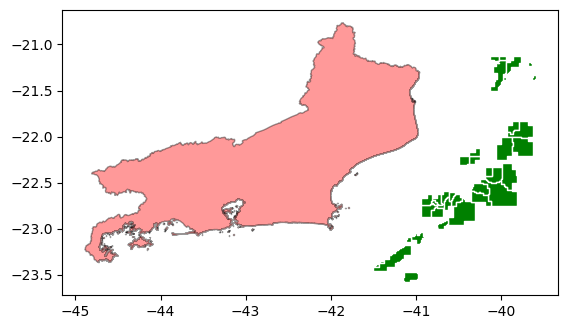

In [9]:
f, a = plt.subplots()

geo_s.plot(ax=a,edgecolor='k',facecolor='r',alpha=.4)
geo_cp.plot(ax=a,edgecolor='w',facecolor='g',alpha=1.0);

- Selecionando poços (onshore ou offshore) que se tornaram públicos em 2022 e em 2023

In [10]:
# para onshore, 'T' 
p2022_m = p2022_s[p2022_s['TERRA_MAR'] == 'M']
p2022_tcm = p2022_m['CAMPO'].unique()

p2023_m = p2023_s[p2023_s['TERRA_MAR'] == 'M']
p2023_tcm = p2023_m['CAMPO'].unique()

- Selecionando campos relacionados aos poços

In [11]:
geo_cp_m_2022 = geo_cp.apply(lambda row: row[geo_cp['NOM_CAMPO'].isin(p2022_tcm)])
geo_cp_m_2023 = geo_cp.apply(lambda row: row[geo_cp['NOM_CAMPO'].isin(p2023_tcm)])

- Plota campos de interesse

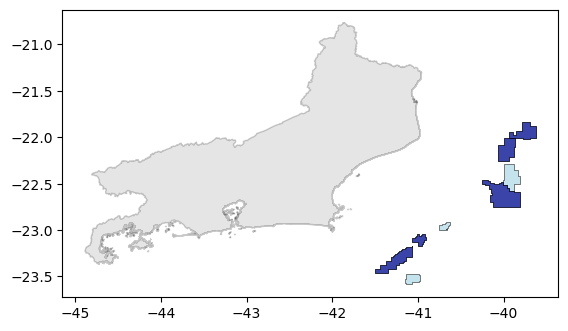

In [12]:
f, a = plt.subplots()

geo_s.plot(ax=a,edgecolor='k',facecolor='gray',alpha=.2)
geo_cp_m_2022.plot(ax=a,edgecolor='k',lw=.5,facecolor='lightblue',alpha=.7)
geo_cp_m_2023.plot(ax=a,edgecolor='k',lw=.5,facecolor='darkblue',alpha=.7);

- Lista de campos participantes da RV

In [13]:
cp_list_2022 =  geo_cp_m_2022.NOM_CAMPO.tolist()
cp_list_2023 =  geo_cp_m_2023.NOM_CAMPO.tolist()

print('Atividade de divulgação em 2022 nos campos de: ')
print(*[x for x in cp_list_2022], sep=', ', end='.\n\n')

print('Atividade de divulgação em 2023 nos campos de: ')
print(*[x for x in cp_list_2023], sep=', ', end='.\n')

Atividade de divulgação em 2022 nos campos de: 
POLVO, MARLIM LESTE, MARLIM SUL, RONCADOR, TARTARUGA VERDE, PEREGRINO, ALBACORA, PAPA-TERRA.

Atividade de divulgação em 2023 nos campos de: 
POLVO, MARLIM SUL, RONCADOR, PEREGRINO, ALBACORA.


### RV finalística

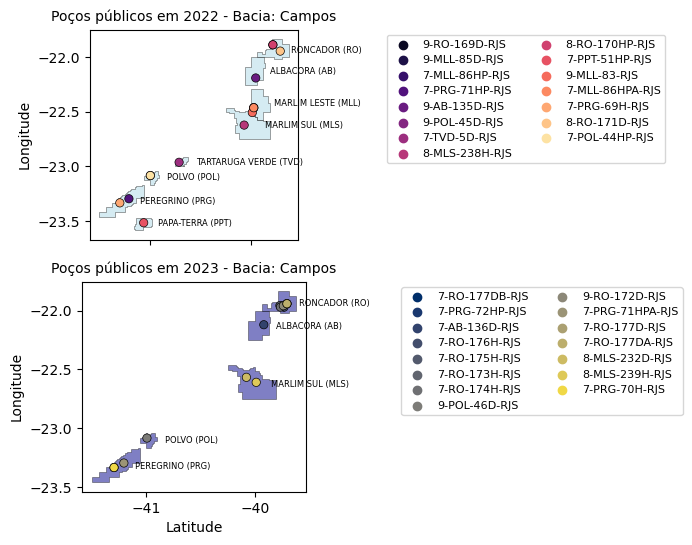

In [14]:
f, a = plt.subplots(2,1,figsize=(14,6),sharex=True)

# --- 2022

geo_cp_m_2022.plot(ax=a[0],edgecolor='k',lw=.5,facecolor='lightblue',alpha=.5)
p2022_m_1 = p2022_m[p2022_m['CAMPO'].isin(cp_list_2022)]
p2022_m_1f = sb.scatterplot(data=p2022_m_1,
                             x='LONGITUDE1',
                             y='LATITUDE_1',
                             hue='POCO',
                             marker='o',edgecolor='k',
                             palette='magma',
                             ax=a[0])
p2022_m_1f.legend(bbox_to_anchor=(1.4,1),ncol=2,fontsize=8)

a[0].set_ylabel('Longitude')
a[0].set_title(f'Poços públicos em 2022 - Bacia: {basin}',fontsize=10)

geo_cp_m_2022.apply(lambda x: a[0].annotate(
                            text=f'{x.NOM_CAMPO} ({x.SIG_CAMPO})',
                            xy=np.array(x.geometry.centroid.coords[0]) + np.array([0.15,0]), 
                            ha='left', 
                            va='center',
                            color = "black",
                            fontsize=6, 
                            weight='light'),                            
                            axis=1)


# --- 2023

geo_cp_m_2023.plot(ax=a[1],edgecolor='k',lw=.5,facecolor='darkblue',alpha=.5)
p2023_m_1 = p2023_m[p2023_m['CAMPO'].isin(cp_list_2023)]
p2023_m_1f = sb.scatterplot(data=p2023_m_1,
                             x='LONGITUDE_BASE_DD',
                             y='LATITUDE_BASE_DD',
                             hue='POCO',
                             marker='o',edgecolor='k',
                             palette='cividis',
                             ax=a[1])
p2023_m_1f.legend(bbox_to_anchor=(1.4,1),ncol=2,fontsize=8)

a[1].set_xlabel('Latitude')
a[1].set_ylabel('Longitude')
a[1].set_title(f'Poços públicos em 2023 - Bacia: {basin}',fontsize=10)

geo_cp_m_2023.apply(lambda x: a[1].annotate(
                            text=f'{x.NOM_CAMPO} ({x.SIG_CAMPO})',
                            xy=np.array(x.geometry.centroid.coords[0]) + np.array([0.15,0]), 
                            ha='left', 
                            va='center',
                            color = "black",
                            fontsize=6, 
                            weight='light'),                            
                            axis=1);
